In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Logistic Regression, SVM, Decision Tree, Boost, and a NN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


%matplotlib inline
pd.set_option('display.max_columns', None)

thresh_ub = 0.95
thresh_lb = 0.05

# Cleaning and helper functions

In [2]:
solar_without_dist_thresh = pd.read_csv('../new_data/threshold_95percentile/ca_data_version_5.csv')
#solar_without_dist_thresh.drop(columns='Unnamed: 0', index=1, inplace = True)
solar_without_dist_thresh

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,9.1889
1,1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,18.0916
2,2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,51.7247
3,3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,9.6227
4,4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,1.6499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [3]:
distance_thresh = solar_without_dist_thresh['min_distance'].quantile(0.95)
distance_thresh

376.63874999999996

In [4]:
### Look for locations that don't have solar farms and have no feature violated
long_distance_constraint = ((solar_without_dist_thresh['Solar_farm_present']==0) & (solar_without_dist_thresh['feature_violated'].isnull()) \
                                            & (solar_without_dist_thresh['min_distance'] >= distance_thresh))
long_distance = solar_without_dist_thresh.loc[long_distance_constraint]
long_distance

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
6,6,35.412132,-115.389800,0,1.0,2.0,864.0,NaN,6.527775,"[141434.1413381812, 136124.0954096352, 166817....","[173.2232671149272, 168.5816319217624, 213.397...","[5.587847326287974, 6.02077256863437, 6.883804...","[148162.7379302353, 142869.4070327808, 174890....",1.832379e+06,405.5617
140,140,36.878690,-117.849072,0,1.0,0.0,639.0,NaN,6.386666,"[128492.3018898137, 127811.1756327208, 158042....","[158.4554965959694, 159.1760700017676, 200.688...","[5.111467632128046, 5.684859642920272, 6.47383...","[134516.1812690618, 134014.1473248255, 165970....",1.777724e+06,442.5785
161,161,35.509902,-115.993832,0,1.0,2.0,860.0,NaN,6.607981,"[129683.3698839003, 139460.1122901668, 169655....","[159.6131821379072, 173.5768544970778, 217.711...","[5.148812327029266, 6.199173374895635, 7.02295...","[136065.5127620298, 146416.8431842005, 177869....",1.842138e+06,410.2260
164,164,35.568565,-116.166412,0,1.0,1.0,232.0,NaN,6.505455,"[134326.0023383891, 134152.3462391439, 164120....","[167.8295481256568, 169.7495607428846, 213.110...","[5.413856391150221, 6.062484312245878, 6.87454...","[140555.8381742158, 140672.1768397138, 171810....",1.789185e+06,500.2115
204,204,35.685889,-115.497663,0,1.0,2.0,877.0,NaN,6.480138,"[135530.092523047, 133629.5490529925, 164006.9...","[165.7934031766128, 165.7932777545079, 208.392...","[5.348174296019769, 5.921188491232424, 6.72232...","[142044.2965130362, 140297.3994964414, 172144....",1.816785e+06,425.1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,1942,36.448500,-116.490000,0,1.0,0.0,677.0,NaN,6.518310,"[127434.48650282, 127146.3200349195, 166299.66...","[157.3039646189393, 158.295784593015, 213.6623...","[5.074321439320622, 5.653420878321966, 6.89233...","[133494.7490928563, 133395.7948534102, 174265....",1.808813e+06,387.6072
2043,2043,36.076972,-116.036977,0,1.0,0.0,769.0,NaN,6.660173,"[143665.4488511992, 133907.9983662198, 168385....","[177.7666822999402, 168.8681547613739, 217.454...","[5.734409106449684, 6.031005527191923, 7.01465...","[150281.5655128679, 140817.5299301871, 176460....",1.843130e+06,548.5578
2089,2089,36.311621,-116.856734,0,1.0,0.0,-83.0,NaN,6.525715,"[133666.2755004521, 135875.8489995141, 156723....","[167.9954245754158, 172.5019522388283, 205.393...","[5.419207244368253, 6.160784008529583, 6.62560...","[139845.2619451468, 142101.8083229327, 164201....",1.775751e+06,440.7516
2101,2101,36.213851,-116.468428,0,1.0,2.0,780.0,NaN,6.551510,"[136397.2879423771, 135006.4917563437, 163593....","[168.5101375027884, 169.3148019333693, 210.483...","[5.435810887186722, 6.046957211906046, 6.78977...","[142762.4383323136, 141765.4960606013, 171427....",1.823559e+06,379.9231


In [5]:
solar_without_dist_thresh.loc[long_distance_constraint,'Solar_farm_present'] = 0
solar_without_dist_thresh.loc[long_distance_constraint,'feature_violated'] = 'min_distance'
solar_without_dist_thresh.shape

(5000, 15)

In [6]:
#check
solar_without_dist_thresh[solar_without_dist_thresh['feature_violated'] == 'slope'].shape

(800, 15)

### Remove all rows where no feature is violated for solar farms are not present and save this file

In [7]:
no_feature_violated = solar_without_dist_thresh.loc[(solar_without_dist_thresh['feature_violated'].isnull()) & (solar_without_dist_thresh['Solar_farm_present']==0)]
no_feature_violated.shape

(2059, 15)

In [8]:
no_solar_farms0 = solar_without_dist_thresh.loc[solar_without_dist_thresh['Solar_farm_present']==0]
solar_farms0    = solar_without_dist_thresh.loc[solar_without_dist_thresh['Solar_farm_present']==1]
#
no_solar_farms_nandrop = no_solar_farms0.dropna(subset =['feature_violated'])
solar_final0    = pd.concat([solar_farms0,no_solar_farms_nandrop])
solar_final0

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
3729,3729,36.177601,-120.109001,1,1.0,0.0,119.0,NaN,5.988686,"[94729.03706566579, 112899.4317807716, 148815....","[117.2264253417953, 143.5962623979706, 193.969...","[3.781497591670815, 5.128437942784665, 6.25709...","[99456.86078053594, 118253.1308946665, 155783....",1.643483e+06,51.2865
3730,3730,33.265202,-116.328003,1,1.0,1.0,164.0,NaN,6.663122,"[145947.9535344609, 142834.661946108, 172511.5...","[184.4958804592433, 182.799235309969, 226.3683...","[5.9514800148143, 6.528544118213177, 7.3022034...","[152913.6057181737, 149334.5490715083, 180501....",1.818351e+06,101.7398
3731,3731,34.823002,-118.348000,1,1.0,0.0,768.0,NaN,6.696370,"[141910.6800494553, 137028.811976832, 173116.9...","[174.5395287168338, 171.1071960003887, 218.391...","[5.630307377962379, 6.110971285728167, 7.04489...","[148793.0135197195, 144002.1003871498, 181749....",1.878859e+06,32.3959
3732,3732,34.707401,-118.305000,1,1.0,0.0,748.0,NaN,6.660706,"[128241.1482835144, 137774.940553894, 173170.4...","[160.4580289181927, 171.7472105871453, 223.264...","[5.176065448973959, 6.133828949540904, 7.20209...","[134241.0719142978, 144436.8702194193, 181533....",1.851904e+06,13.7756
3733,3733,34.708599,-118.274002,1,1.0,0.0,731.0,NaN,6.708849,"[142734.0003740294, 138850.805634565, 173172.2...","[176.3520191843734, 174.3075934660958, 223.422...","[5.688774812399141, 6.225271195217706, 7.20717...","[149444.0213297507, 145674.4399659933, 181504....",1.868110e+06,10.6077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [9]:
### Make sure that there is no NaN for any feature
feature_list = ['slope','elevation','land_cover','ac_annual','min_distance']
solar_final0 = solar_final0.dropna(subset = feature_list)
solar_final0.drop('Unnamed: 0',axis=1,inplace=True)
solar_final0.shape

(2884, 14)

In [10]:
solar_final0.to_csv('../new_data/threshold_95percentile/ca_data_version_6.csv',index=False)

### Now proceeed with model building

In [11]:
solar_final = pd.read_csv('../new_data/threshold_95percentile/ca_data_version_6.csv')
solar_final

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,36.177601,-120.109001,1,1.0,0.0,119.0,NaN,5.988686,"[94729.03706566579, 112899.4317807716, 148815....","[117.2264253417953, 143.5962623979706, 193.969...","[3.781497591670815, 5.128437942784665, 6.25709...","[99456.86078053594, 118253.1308946665, 155783....",1.643483e+06,51.2865
1,33.265202,-116.328003,1,1.0,1.0,164.0,NaN,6.663122,"[145947.9535344609, 142834.661946108, 172511.5...","[184.4958804592433, 182.799235309969, 226.3683...","[5.9514800148143, 6.528544118213177, 7.3022034...","[152913.6057181737, 149334.5490715083, 180501....",1.818351e+06,101.7398
2,34.823002,-118.348000,1,1.0,0.0,768.0,NaN,6.696370,"[141910.6800494553, 137028.811976832, 173116.9...","[174.5395287168338, 171.1071960003887, 218.391...","[5.630307377962379, 6.110971285728167, 7.04489...","[148793.0135197195, 144002.1003871498, 181749....",1.878859e+06,32.3959
3,34.707401,-118.305000,1,1.0,0.0,748.0,NaN,6.660706,"[128241.1482835144, 137774.940553894, 173170.4...","[160.4580289181927, 171.7472105871453, 223.264...","[5.176065448973959, 6.133828949540904, 7.20209...","[134241.0719142978, 144436.8702194193, 181533....",1.851904e+06,13.7756
4,34.708599,-118.274002,1,1.0,0.0,731.0,NaN,6.708849,"[142734.0003740294, 138850.805634565, 173172.2...","[176.3520191843734, 174.3075934660958, 223.422...","[5.688774812399141, 6.225271195217706, 7.20717...","[149444.0213297507, 145674.4399659933, 181504....",1.868110e+06,10.6077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
2880,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
2881,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
2882,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [12]:
solar_final.describe()

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2.884000e+03,2884.000000
mean,37.103096,-119.598448,0.163315,0.741678,4.633495,710.074549,5.974094,1.673572e+06,146.301482
std,2.713619,2.461154,0.369717,0.437788,8.214975,680.743993,0.584004,1.537223e+05,133.951538
min,32.537677,-124.450274,0.000000,0.000000,0.000000,-85.000000,4.113513,1.194338e+06,1.123700
25%,34.766846,-121.451689,0.000000,0.000000,0.000000,34.000000,5.605303,1.582380e+06,35.118600
50%,36.644041,-119.978377,0.000000,1.000000,1.000000,670.000000,5.950324,1.655665e+06,94.283400
75%,39.342509,-117.567972,0.000000,1.000000,4.000000,1220.000000,6.533265,1.818790e+06,235.533525
max,42.001868,-114.268027,1.000000,1.000000,44.000000,3699.000000,6.973360,1.963854e+06,600.921800


In [13]:
solar_final.isnull().sum()

Latitude                0
Longitude               0
Solar_farm_present      0
land_cover              0
slope                   0
elevation               0
feature_violated      471
solrad_annual           0
ac_monthly              0
poa_monthly             0
solrad_monthly          0
dc_monthly              0
ac_annual               0
min_distance            0
dtype: int64

In [14]:
solar_existing     = solar_final[solar_final['Solar_farm_present']==1]
solar_non_existing = solar_final[solar_final['Solar_farm_present']==0]

In [15]:
solar_non_existing

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
471,35.412132,-115.389800,0,1.0,2.0,864.0,min_distance,6.527775,"[141434.1413381812, 136124.0954096352, 166817....","[173.2232671149272, 168.5816319217624, 213.397...","[5.587847326287974, 6.02077256863437, 6.883804...","[148162.7379302353, 142869.4070327808, 174890....",1.832379e+06,405.5617
472,36.878690,-117.849072,0,1.0,0.0,639.0,min_distance,6.386666,"[128492.3018898137, 127811.1756327208, 158042....","[158.4554965959694, 159.1760700017676, 200.688...","[5.111467632128046, 5.684859642920272, 6.47383...","[134516.1812690618, 134014.1473248255, 165970....",1.777724e+06,442.5785
473,35.509902,-115.993832,0,1.0,2.0,860.0,min_distance,6.607981,"[129683.3698839003, 139460.1122901668, 169655....","[159.6131821379072, 173.5768544970778, 217.711...","[5.148812327029266, 6.199173374895635, 7.02295...","[136065.5127620298, 146416.8431842005, 177869....",1.842138e+06,410.2260
474,35.568565,-116.166412,0,1.0,1.0,232.0,min_distance,6.505455,"[134326.0023383891, 134152.3462391439, 164120....","[167.8295481256568, 169.7495607428846, 213.110...","[5.413856391150221, 6.062484312245878, 6.87454...","[140555.8381742158, 140672.1768397138, 171810....",1.789185e+06,500.2115
475,35.685889,-115.497663,0,1.0,2.0,877.0,min_distance,6.480138,"[135530.092523047, 133629.5490529925, 164006.9...","[165.7934031766128, 165.7932777545079, 208.392...","[5.348174296019769, 5.921188491232424, 6.72232...","[142044.2965130362, 140297.3994964414, 172144....",1.816785e+06,425.1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
2880,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
2881,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
2882,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [16]:
solar_non_existing_sample = solar_non_existing.sample(500, random_state = 42)

In [17]:
solar_non_existing_sample

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
1236,41.552124,-120.157335,0,1.0,1.0,1385.0,elevation,5.708481,"[90824.11839699467, 102829.6556834618, 143499....","[107.8519946084084, 124.0311720672096, 178.041...","[3.47909660027124, 4.429684716686057, 5.743285...","[95389.38922327725, 108338.5711922057, 150954....",1.631080e+06,270.3715
2858,34.199777,-119.272860,0,0.0,0.0,0.0,land_cover,5.548646,"[119388.0465199253, 119892.8236904812, 136898....","[151.1261468250299, 153.6178619026519, 175.816...","[4.875036994355805, 5.486352210808996, 5.67151...","[125031.9986245192, 125504.6847665692, 143415....",1.549850e+06,7.0732
2633,41.825881,-122.961768,0,0.0,2.0,494.0,land_cover,5.358604,"[81777.94319949651, 88208.8431930181, 119106.0...","[101.1324268757145, 112.3246005397691, 156.127...","[3.262336350829501, 4.011592876420324, 5.03637...","[85920.33108380224, 92608.6086730362, 124939.9...",1.439828e+06,216.0598
2304,38.051937,-122.120438,0,0.0,0.0,1.0,land_cover,5.578596,"[89869.58539348899, 105640.842545473, 134581.3...","[110.0128495733674, 130.8310216054974, 169.867...","[3.548801599140885, 4.672536485910622, 5.47959...","[94349.4240644087, 110747.6585552315, 141041.7...",1.581137e+06,15.8505
2285,34.434426,-120.437778,0,0.0,0.0,0.0,land_cover,5.893005,"[108458.3620016632, 119036.1827334248, 153523....","[134.6389190773575, 146.861415405863, 191.7419...","[4.343190937979274, 5.245050550209392, 6.18522...","[113696.0251851082, 124712.4168489491, 160857....",1.706744e+06,81.2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,33.163409,-116.835161,0,1.0,21.0,507.0,slope,6.133979,"[131130.4989592696, 121180.6818841291, 141020....","[163.2696125959735, 153.3947864982667, 181.791...","[5.266761696644306, 5.478385232080953, 5.86423...","[137260.8498054741, 126925.2806200898, 147750....",1.710004e+06,38.3799
674,41.786773,-121.732132,0,1.0,1.0,1297.0,elevation,5.647868,"[94911.62383536712, 100898.2624121443, 137732....","[114.8911393100053, 122.8726025850188, 171.294...","[3.706165784193718, 4.388307235179242, 5.52563...","[99583.63434035424, 105898.473017372, 144839.2...",1.598426e+06,205.2744
2082,38.658115,-119.898464,0,1.0,22.0,2784.0,slope,6.264465,"[99844.13610653757, 108395.0268360737, 151716....","[122.1171688476623, 135.4605597777643, 195.551...","[3.939263511214913, 4.837877134920153, 6.30810...","[104980.0458990117, 114493.4969472504, 160785....",1.732883e+06,171.5859
645,41.552124,-122.336163,0,1.0,2.0,931.0,elevation,5.545210,"[91905.51549225205, 92629.21799297993, 131613....","[112.6000742039042, 115.2211056464884, 165.666...","[3.632260458190458, 4.115039487374587, 5.34409...","[96423.42967688404, 97220.22276542906, 138053....",1.539033e+06,131.4506


In [18]:
solar = pd.concat([solar_existing, solar_non_existing_sample])

In [19]:
solar.describe()

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,9.710000e+02,971.000000
mean,36.482999,-119.231411,0.485067,0.834192,3.031926,565.375901,6.094958,1.698638e+06,108.740940
std,2.471374,2.340868,0.500035,0.372100,6.702362,606.876661,0.528262,1.405410e+05,122.008707
min,32.618301,-124.450274,0.000000,0.000000,0.000000,-83.000000,4.242356,1.241787e+06,2.540700
25%,34.645849,-121.048905,0.000000,1.000000,0.000000,56.000000,5.724602,1.609009e+06,22.380400
50%,35.980701,-119.294433,0.000000,1.000000,1.000000,321.000000,6.052929,1.674875e+06,58.239900
75%,38.130154,-117.492956,1.000000,1.000000,2.000000,951.000000,6.610528,1.837796e+06,155.783600
max,41.982314,-114.311172,1.000000,1.000000,38.000000,3568.000000,6.926908,1.951958e+06,600.335400


In [20]:
solar.to_csv('ML_data_95.csv', index = False)

In [21]:
solar.columns

Index(['Latitude', 'Longitude', 'Solar_farm_present', 'land_cover', 'slope',
       'elevation', 'feature_violated', 'solrad_annual', 'ac_monthly',
       'poa_monthly', 'solrad_monthly', 'dc_monthly', 'ac_annual',
       'min_distance'],
      dtype='object')

In [22]:
solar.describe()

,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000,9.710000e+02,971.000000
mean,36.482999,-119.231411,0.485067,0.834192,3.031926,565.375901,6.094958,1.698638e+06,108.740940
std,2.471374,2.340868,0.500035,0.372100,6.702362,606.876661,0.528262,1.405410e+05,122.008707
min,32.618301,-124.450274,0.000000,0.000000,0.000000,-83.000000,4.242356,1.241787e+06,2.540700
25%,34.645849,-121.048905,0.000000,1.000000,0.000000,56.000000,5.724602,1.609009e+06,22.380400
50%,35.980701,-119.294433,0.000000,1.000000,1.000000,321.000000,6.052929,1.674875e+06,58.239900
75%,38.130154,-117.492956,1.000000,1.000000,2.000000,951.000000,6.610528,1.837796e+06,155.783600
max,41.982314,-114.311172,1.000000,1.000000,38.000000,3568.000000,6.926908,1.951958e+06,600.335400


In [23]:
X = solar[feature_list]
y = solar['Solar_farm_present']

# Train-Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = feature_list)
X_test  = pd.DataFrame(imputer.transform(X_test), columns = feature_list )

In [26]:
X_train.describe()

,slope,elevation,land_cover,ac_annual,min_distance
count,776.000000,776.000000,776.000000,7.760000e+02,776.000000
mean,3.052835,586.048969,0.842784,1.701761e+06,109.945259
std,6.590201,611.319689,0.364240,1.421020e+05,121.972232
min,0.000000,-82.000000,0.000000,1.241787e+06,2.540700
25%,0.000000,59.750000,1.000000,1.610228e+06,23.082725
50%,1.000000,429.000000,1.000000,1.680505e+06,58.107100
75%,2.000000,978.000000,1.000000,1.839304e+06,157.383025
max,38.000000,3568.000000,1.000000,1.951958e+06,600.335400


In [27]:
X_test.describe()

,slope,elevation,land_cover,ac_annual,min_distance
count,195.000000,195.000000,195.00000,1.950000e+02,195.000000
mean,2.948718,483.107692,0.80000,1.686212e+06,103.948367
std,7.148458,583.149433,0.40103,1.337795e+05,122.349989
min,0.000000,-83.000000,0.00000,1.264569e+06,3.195300
25%,0.000000,31.500000,1.00000,1.607441e+06,19.889750
50%,0.000000,157.000000,1.00000,1.663124e+06,59.591200
75%,2.000000,872.500000,1.00000,1.806347e+06,131.180550
max,38.000000,3292.000000,1.00000,1.927292e+06,527.021100


In [28]:
sd = StandardScaler()

In [29]:
features_excluding_LC = ['slope', 'elevation','ac_annual', 'min_distance']
X_train_excluding_LC = X_train[features_excluding_LC]
X_train_excluding_LC = pd.DataFrame(sd.fit_transform(X_train_excluding_LC), columns = features_excluding_LC)

X_test_excluding_LC = X_test[features_excluding_LC]
X_test_excluding_LC = pd.DataFrame(sd.transform(X_test_excluding_LC), columns = features_excluding_LC)

In [30]:
X_train_excluding_LC.describe()

,slope,elevation,ac_annual,min_distance
count,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02
mean,3.319223e-17,2.632488e-17,-1.341424e-15,5.951711e-17
std,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00
min,-4.635373e-01,-1.093503e+00,-3.239015e+00,-8.811336e-01
25%,-4.635373e-01,-8.614779e-01,-6.445476e-01,-7.126094e-01
50%,-3.116990e-01,-2.570672e-01,-1.496774e-01,-4.252738e-01
75%,-1.598607e-01,6.415691e-01,9.685483e-01,3.891735e-01
max,5.306318e+00,4.881037e+00,1.761826e+00,4.023099e+00


In [31]:
X_test_excluding_LC.describe()

,slope,elevation,ac_annual,min_distance
count,195.000000,195.000000,195.000000,195.000000
mean,-0.015809,-0.168500,-0.109486,-0.049198
std,1.085410,0.954534,0.942040,1.003744
min,-0.463537,-1.095140,-3.078592,-0.875763
25%,-0.463537,-0.907719,-0.664172,-0.738804
50%,-0.463537,-0.702293,-0.272070,-0.413098
75%,-0.159861,0.468880,0.736468,0.174212
max,5.306318,4.429264,1.588132,3.421638


In [32]:
X_train = pd.concat([X_train_excluding_LC, X_train['land_cover']], axis=1)
X_test = pd.concat([X_test_excluding_LC, X_test['land_cover']], axis=1)

In [33]:
X_train.describe()

,slope,elevation,ac_annual,min_distance,land_cover
count,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,776.000000
mean,3.319223e-17,2.632488e-17,-1.341424e-15,5.951711e-17,0.842784
std,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,0.364240
min,-4.635373e-01,-1.093503e+00,-3.239015e+00,-8.811336e-01,0.000000
25%,-4.635373e-01,-8.614779e-01,-6.445476e-01,-7.126094e-01,1.000000
50%,-3.116990e-01,-2.570672e-01,-1.496774e-01,-4.252738e-01,1.000000
75%,-1.598607e-01,6.415691e-01,9.685483e-01,3.891735e-01,1.000000
max,5.306318e+00,4.881037e+00,1.761826e+00,4.023099e+00,1.000000


In [34]:
X_test.describe()

,slope,elevation,ac_annual,min_distance,land_cover
count,195.000000,195.000000,195.000000,195.000000,195.00000
mean,-0.015809,-0.168500,-0.109486,-0.049198,0.80000
std,1.085410,0.954534,0.942040,1.003744,0.40103
min,-0.463537,-1.095140,-3.078592,-0.875763,0.00000
25%,-0.463537,-0.907719,-0.664172,-0.738804,1.00000
50%,-0.463537,-0.702293,-0.272070,-0.413098,1.00000
75%,-0.159861,0.468880,0.736468,0.174212,1.00000
max,5.306318,4.429264,1.588132,3.421638,1.00000


# Confusion Matrix Functions

In [35]:
def plot_confusion_matrix(y_true, y_pred,ml_method):
    
    figsize = (10, 10)
    fig, ax = plt.subplots(figsize=figsize)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    ax.set(title="Confusion Matrix : " + ml_method,
           xlabel="Predicted label",
           ylabel="True label",
           #xticks=np.arange(n_classes),
           #yticks=np.arange(n_classes),
           #xticklabels=labels,
           #yticklabels=labels
          )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i, j] > threshold else "black",
               size=15)
        

# Logistic Regression:

In [36]:
params = {"C": np.logspace(-1, 1, 100),
          "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

lr = LogisticRegression(max_iter=3000, random_state=104)  
lr_cv = GridSearchCV(lr, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
lr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=3000, random_state=104),
             n_jobs=-1,
             param_grid={'C': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.278...
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy', verbose=1)

In [37]:
lr_tuned = LogisticRegression(**lr_cv.best_params_, max_iter=3000, random_state=104)
lr_tuned.fit(X_train, y_train)
y_pred_train_lr = lr_tuned.predict(X_train) 
y_pred_test_lr = lr_tuned.predict(X_test)

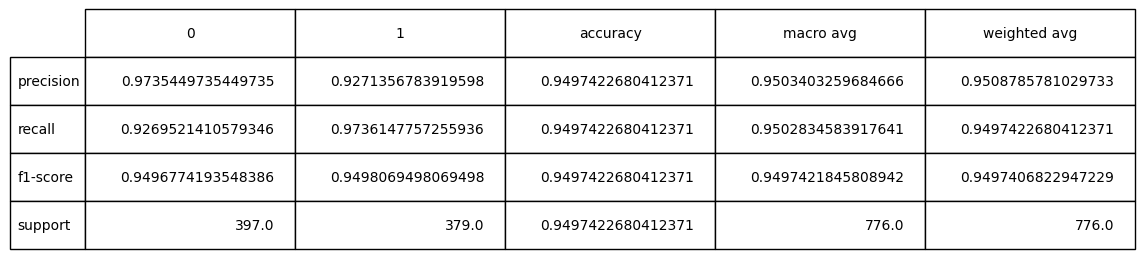

In [38]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_lr, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

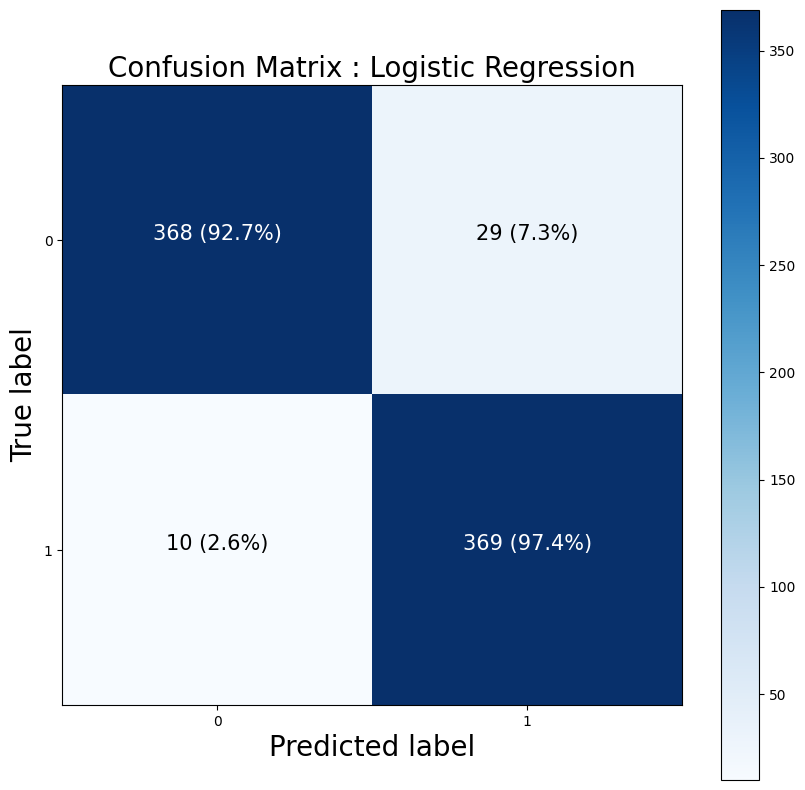

In [39]:
plot_confusion_matrix(y_train, y_pred_train_lr,'Logistic Regression')

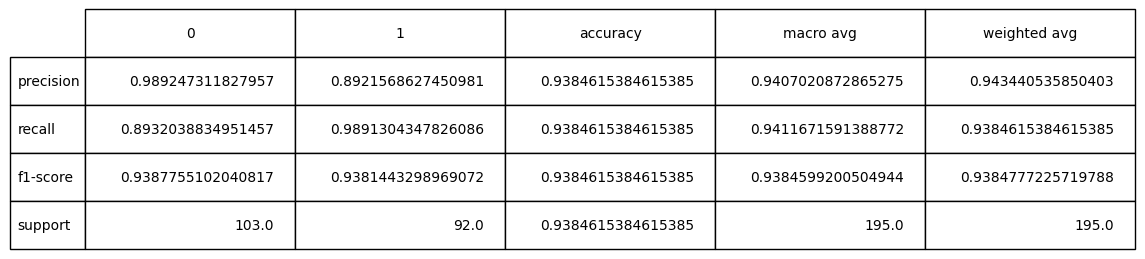

In [40]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_lr, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

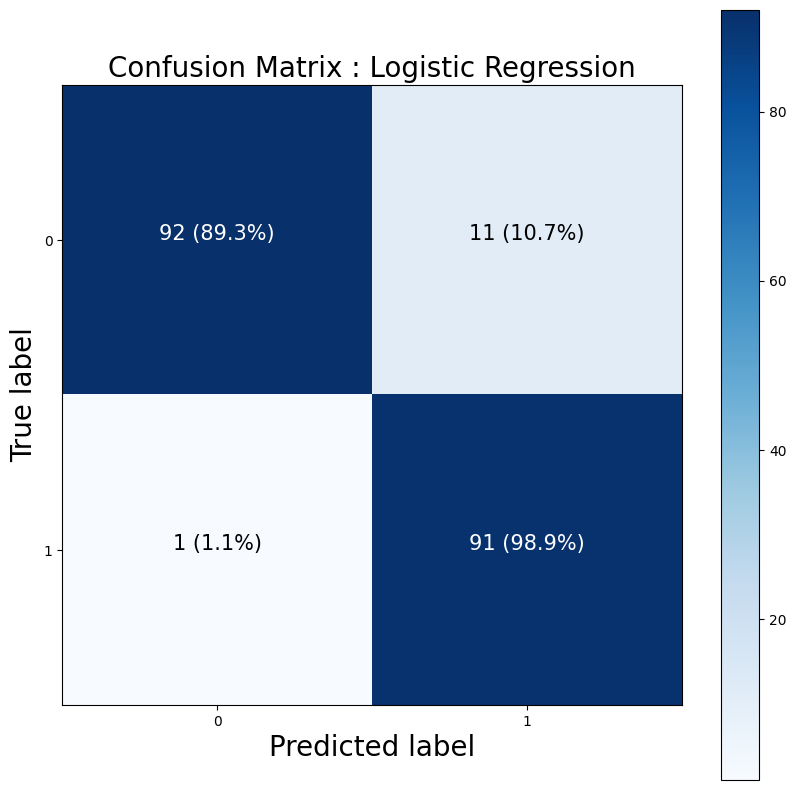

In [41]:
plot_confusion_matrix(y_test, y_pred_test_lr, 'Logistic Regression' )

# Decision Tree Classifier:

In [42]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 20))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))
          }

tree = DecisionTreeClassifier(random_state=406)

tree_cv = GridSearchCV(tree, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)

tree_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=406),
             n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4],
                         'splitter': ('best', 'random')},
             scoring='accuracy', verbose=1)

In [43]:
tree_tuned = DecisionTreeClassifier(**tree_cv.best_params_, random_state = 406)
tree_tuned.fit(X_train, y_train)
y_pred_train_tree = tree_tuned.predict(X_train) 
y_pred_test_tree = tree_tuned.predict(X_test)

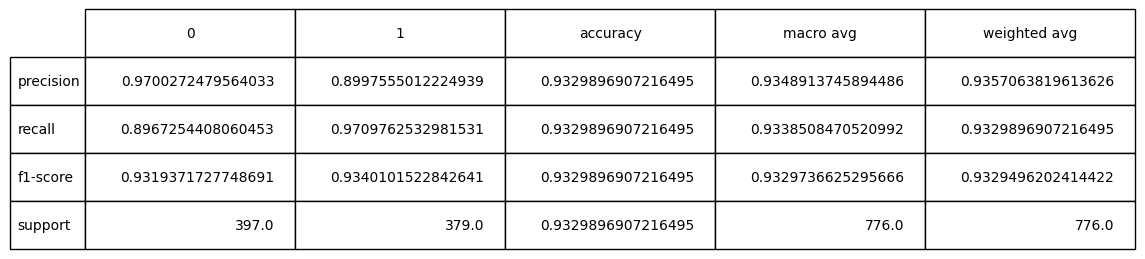

In [44]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_tree, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

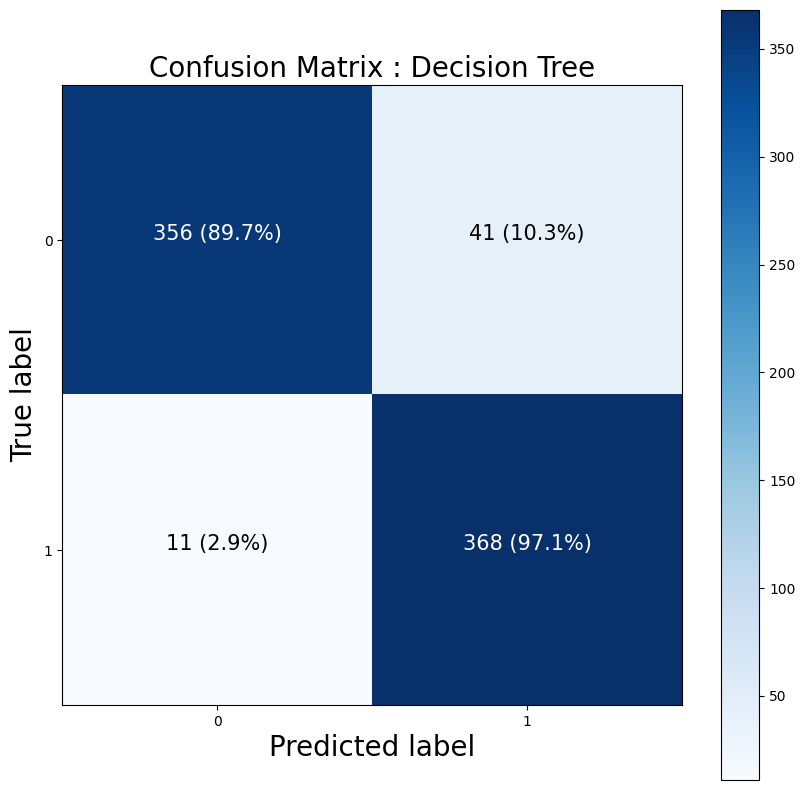

In [45]:
plot_confusion_matrix(y_train, y_pred_train_tree, 'Decision Tree')

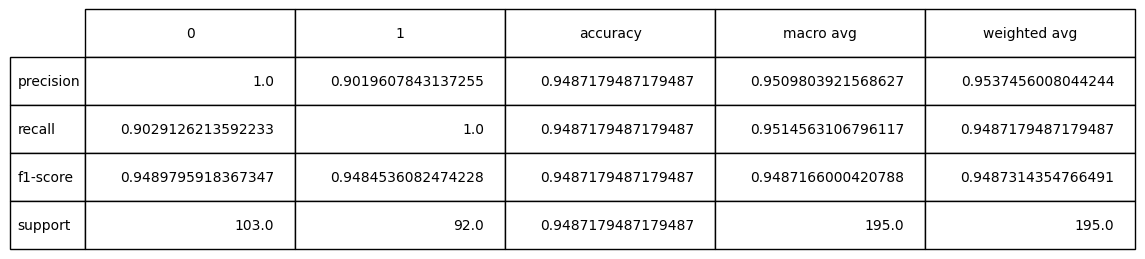

In [46]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_tree, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

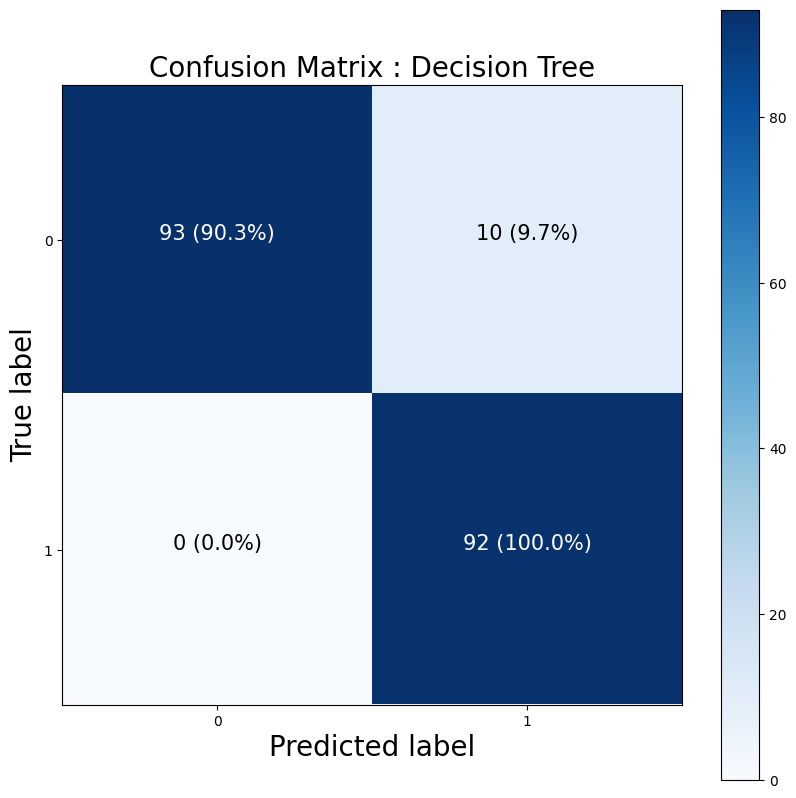

In [47]:
plot_confusion_matrix(y_test, y_pred_test_tree, 'Decision Tree')

# Support Vector Machine:

In [48]:
svm = SVC(kernel='rbf', gamma=0.1, C=4.0, random_state= 113)

params = {"C":(0.1, 1, 10), 
          "gamma":(0.01, 0.1, 1), 
          "kernel":('linear', 'rbf')}               


svm_cv = GridSearchCV(svm, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
svm_cv.fit(X_train, y_train)
    

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(C=4.0, gamma=0.1, random_state=113), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10), 'gamma': (0.01, 0.1, 1),
                         'kernel': ('linear', 'rbf')},
             scoring='accuracy', verbose=1)

In [49]:
svm_tuned = SVC(**svm_cv.best_params_, random_state=113)
svm_tuned.fit(X_train, y_train)
y_pred_train_svm = svm_tuned.predict(X_train) 
y_pred_test_svm = svm_tuned.predict(X_test)

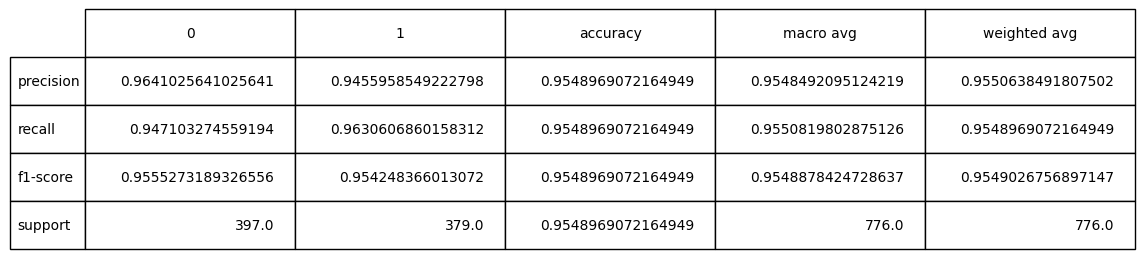

In [50]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_svm, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

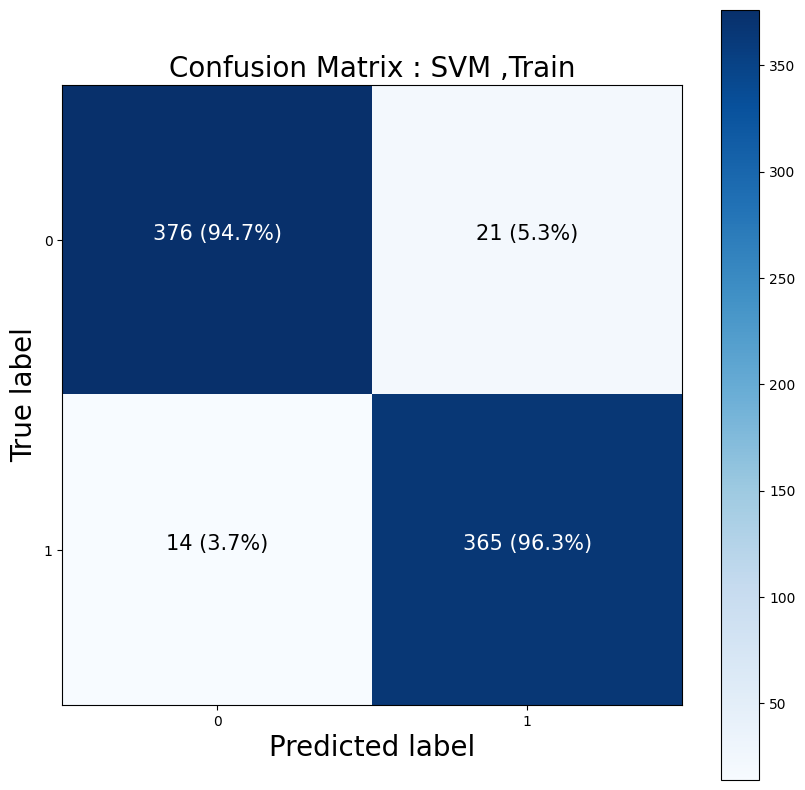

In [51]:
plot_confusion_matrix(y_train, y_pred_train_svm, 'SVM ,Train' )

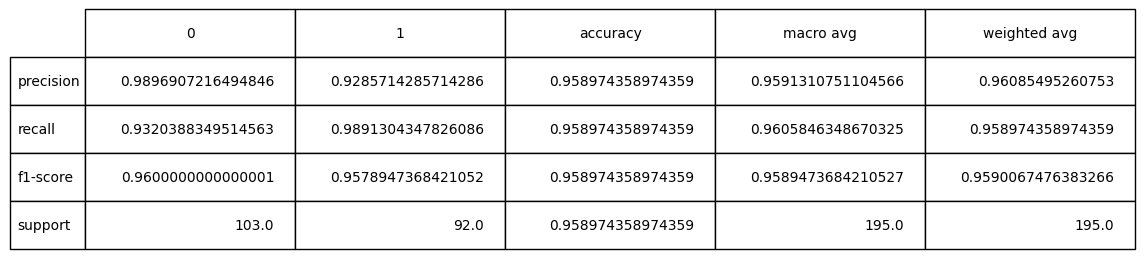

In [52]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_svm, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

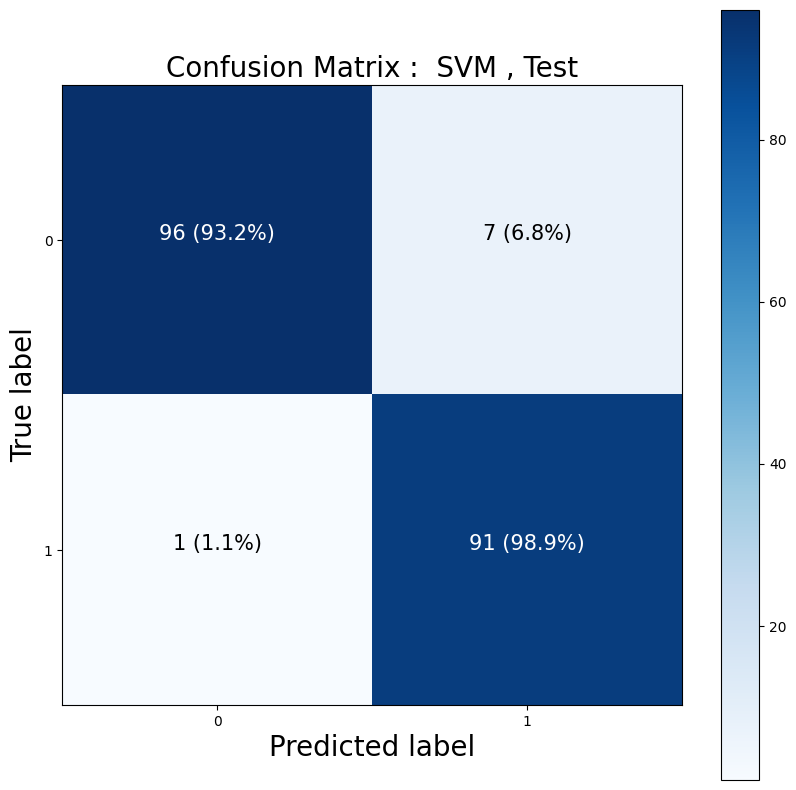

In [53]:
plot_confusion_matrix(y_test, y_pred_test_svm, ' SVM , Test')

# XGBoost

In [54]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1,seed=42)

parameters = {
    'max_depth':(list(range(1, 20))),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
xgb_cv = GridSearchCV(xgb_model, parameters, scoring="roc_auc", n_jobs=-1, verbose=1, cv=10)
xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc', verbose=1)

In [55]:
y_pred_train_xgb = xgb_cv.predict(X_train)
y_pred_test_xgb  = xgb_cv.predict(X_test)

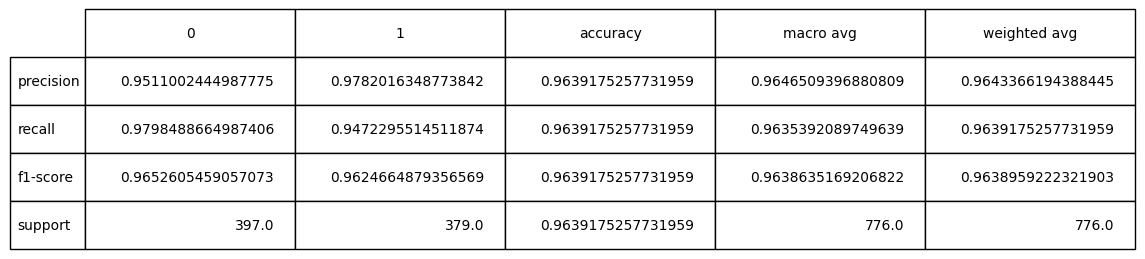

In [56]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_xgb, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

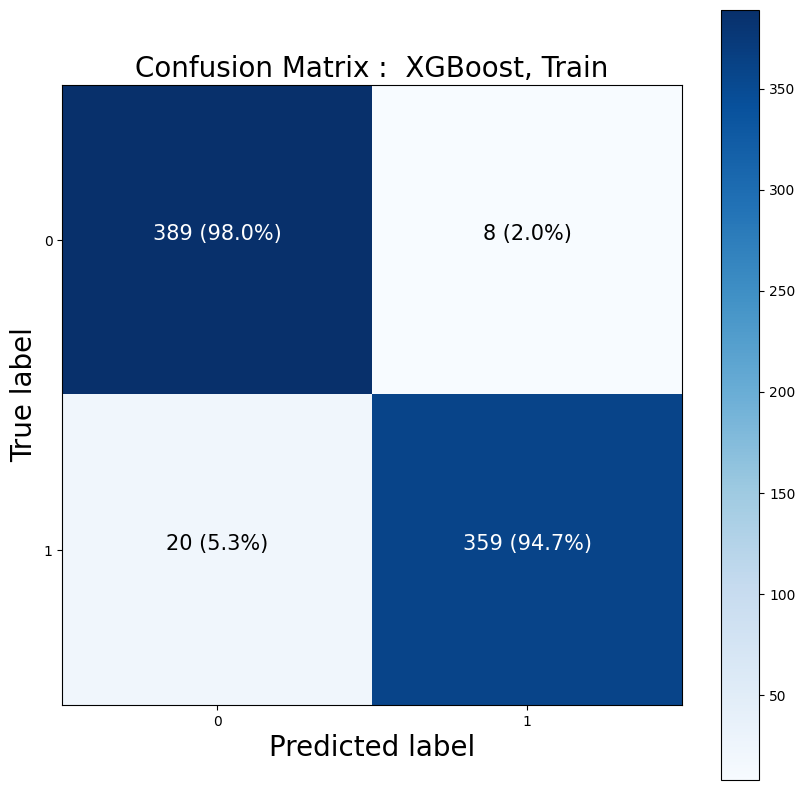

In [57]:
plot_confusion_matrix(y_train, y_pred_train_xgb, ' XGBoost, Train' )

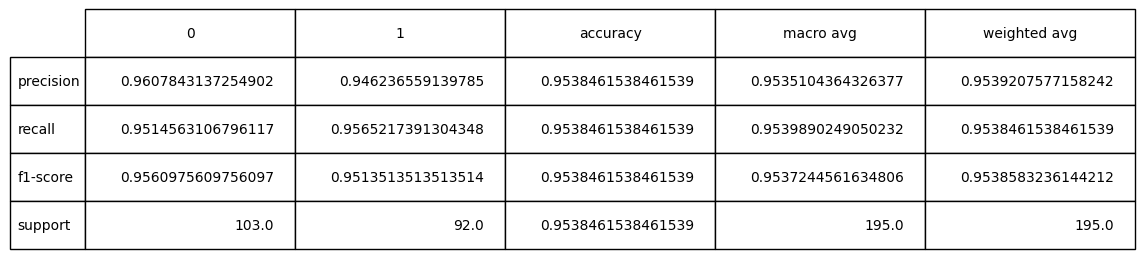

In [58]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_xgb, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

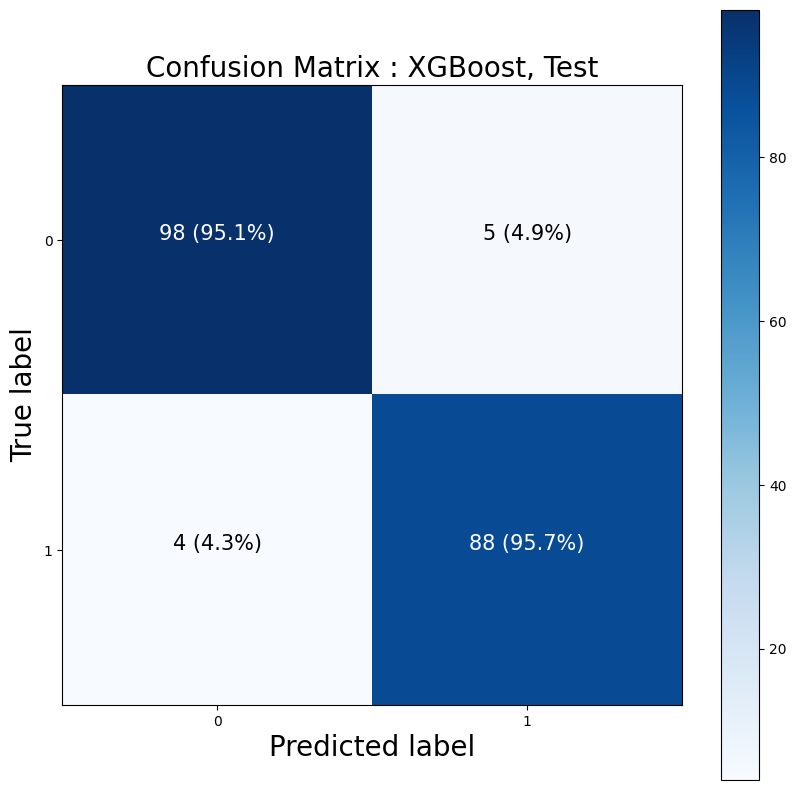

In [59]:
plot_confusion_matrix(y_test, y_pred_test_xgb, 'XGBoost, Test')

# Deep Learning

In [60]:
input_shape = [X_train.shape[1]]

In [61]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=input_shape))
model.add(Dense(1, activation='sigmoid'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 0.5918 - accuracy: 0.6946
Epoch 2/100
25/25 [==============================] - 0s 930us/step - loss: 0.5370 - accuracy: 0.8325
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.4932 - accuracy: 0.8376
Epoch 4/100
25/25 [==============================] - 0s 892us/step - loss: 0.4568 - accuracy: 0.8454
Epoch 5/100
25/25 [==============================] - 0s 962us/step - loss: 0.4251 - accuracy: 0.8531
Epoch 6/100
25/25 [==============================] - 0s 755us/step - loss: 0.3973 - accuracy: 0.8802
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.3719 - accuracy: 0.8892
Epoch 8/100
25/25 [==============================] - 0s 506us/step - loss: 0.3494 - accuracy: 0.9034
Epoch 9/100
25/25 [==============================] - 0s 461us/step - loss: 0.3292 - accuracy: 0.9111
Epoch 10/100
25/25 [==============================] - 0s 480us/step - loss: 0.3113 - accuracy: 0.

In [62]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.9487
[0.11674357950687408, 0.9487179517745972]
Loss =  0.11674357950687408
Accuracy =  0.9487179517745972


In [63]:
y_pred_train_DL = model.predict(X_train) 
y_pred_test_DL = model.predict(X_test)

7/7 [==============================] - 0s 433us/step


In [64]:
actual_train = np.array(y_train)
predicted_train = tf.squeeze(y_pred_train_DL)
predicted_train = np.array([1 if x >= 0.5 else 0 for x in predicted_train])

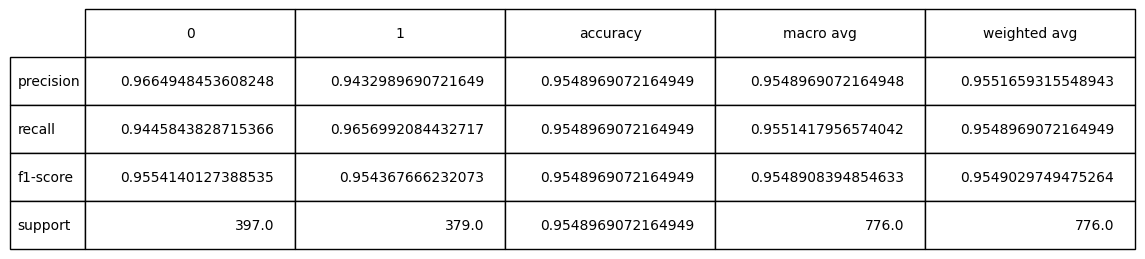

In [65]:
df = pd.DataFrame(classification_report(actual_train, predicted_train, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

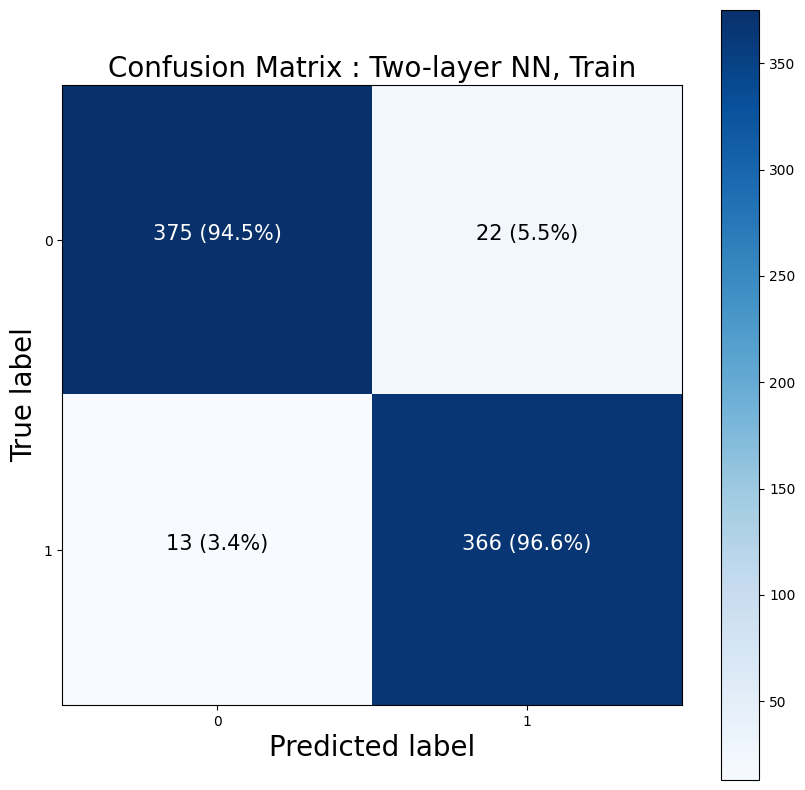

In [66]:
plot_confusion_matrix(actual_train,predicted_train, 'Two-layer NN, Train')

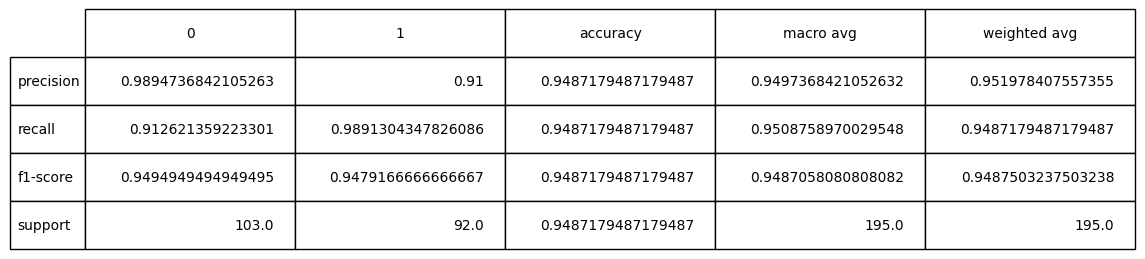

In [67]:
actual_test = np.array(y_test)
predicted_test = tf.squeeze(y_pred_test_DL)
predicted_test = np.array([1 if x >= 0.5 else 0 for x in predicted_test])


df = pd.DataFrame(classification_report(actual_test, predicted_test, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

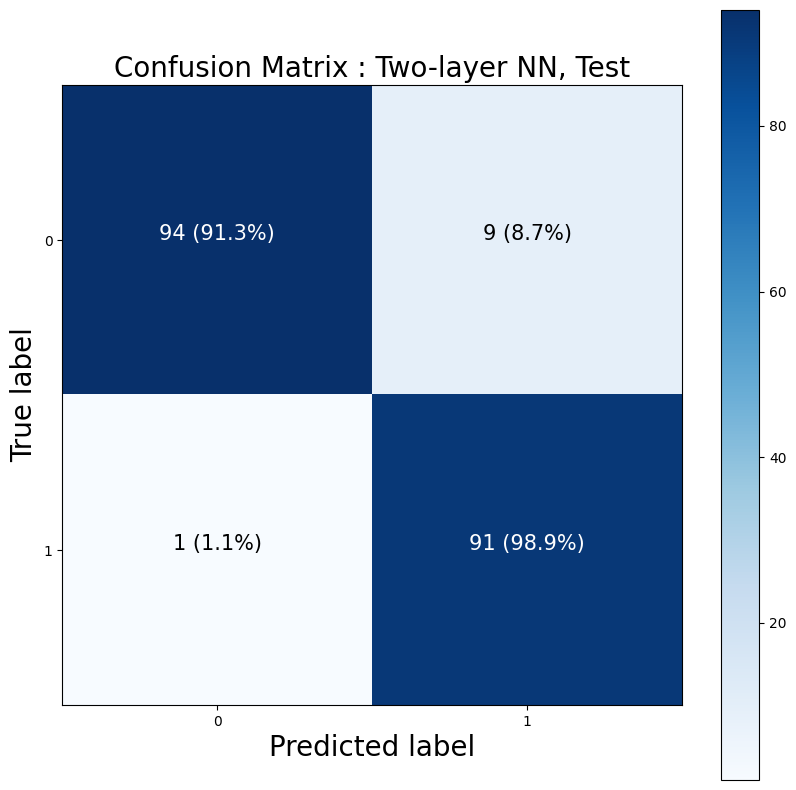

In [68]:
plot_confusion_matrix(actual_test,predicted_test, 'Two-layer NN, Test')